# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
from transformers import logging
logging.set_verbosity_error()
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-lc-kfold'
epochs = 10
batch_size = 64
sequence_length = 80
min_increment = 200

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-3/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-3/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [8]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [9]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

# BUILD DATASET & DATALOADERS

In [10]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, seed, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(f"Fold {trials + 1} - Training with {current_train_size} samples...")

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders using the fold's data
    current_X_train = [X_train_fold[i] for i in train_indices]
    current_y_train = [y_train_fold[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val_fold, y_val_fold)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-fold-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result
        
        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Best result for {current_train_size} samples: F1 Micro: {round(best_result['f1_micro'], 4)}")
    accelerator.print(best_result['report'])
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, X_train_fold, y_train_fold, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train_fold[i] for i in temp],
                'HS': [y_train_fold[i][0] for i in temp],
                'Abusive': [y_train_fold[i][1] for i in temp],
                'HS_Individual': [y_train_fold[i][2] for i in temp],
                'HS_Group': [y_train_fold[i][3] for i in temp],
                'HS_Religion': [y_train_fold[i][4] for i in temp],
                'HS_Race': [y_train_fold[i][5] for i in temp],
                'HS_Physical': [y_train_fold[i][6] for i in temp],
                'HS_Gender': [y_train_fold[i][7] for i in temp],
                'HS_Other': [y_train_fold[i][8] for i in temp],
                'HS_Weak': [y_train_fold[i][9] for i in temp],
                'HS_Moderate': [y_train_fold[i][10] for i in temp],
                'HS_Strong': [y_train_fold[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [16]:
from sklearn.model_selection import KFold

N_SPLITS = 5
RANDOM_SEED = 42

# Prepare data for K-Fold
label_columns = data.columns[1:]
X = data['Tweet'].values
y = data[label_columns].values
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# Each element in these lists will be a list of metrics for one fold's learning curve
all_fold_accuracies = []
all_fold_f1_micros = []
all_fold_f1_macros = []
all_fold_data_used = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print("===============================================")
    print(f"STARTING FOLD {fold + 1}/{N_SPLITS}")
    print("===============================================")

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Shared resources for this fold's processes
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    
    # Set seed for reproducibility within the fold
    set_seed(RANDOM_SEED + fold)
    
    # Define the initial labeled pool from the current fold's training data
    total_train_fold_size = len(X_train_fold) + len(X_val_fold)
    initial_train_size = int(0.05 * total_train_fold_size)
    
    train_indices = np.random.choice(range(len(X_train_fold)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train_fold))) - set(train_indices))
    current_train_size = initial_train_size

    # Adjust checkpoints based on the current fold's training size
    checkpoints = [
        # int(0.1 * total_train_fold_size)
        int(0.5 * total_train_fold_size), 
        int(0.6 * total_train_fold_size),
        int(0.7 * total_train_fold_size),
        len(X_train_fold)
    ]
    
    fold_start_time = time.time()
    
    while current_train_size < total_train_fold_size:
        # 1. Train the model on the current labeled set
        train_args = (
            current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros),
            fold, RANDOM_SEED + fold, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns
        )
        notebook_launcher(train_model, train_args, num_processes=2)
        
        # Stop if we've reached the last checkpoint
        if current_train_size >= checkpoints[-1]:
            break

        model = BertForSequenceClassification.from_pretrained(f'{filename}-fold-{fold + 1}-model')
        
        # 3. Perform query strategy to select new samples
        new_samples_shared = manager.list()
        X_pool = [X_train_fold[i] for i in remaining_indices]
        sampling_args = (model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples_shared, fold, X_train_fold, y_train_fold)
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        
        # 4. Update the pools
        newly_acquired_indices = list(new_samples_shared)
        train_indices.extend(newly_acquired_indices)
        remaining_indices = list(set(remaining_indices) - set(newly_acquired_indices))
    
        current_train_size = len(train_indices)
        print(f"\nFold {fold + 1} - New train size: {current_train_size}\n")
    
    fold_end_time = time.time()
    print(f"\nFOLD {fold + 1} COMPLETED in {fold_end_time - fold_start_time:.2f} seconds")
    
    # Store the results for this fold
    all_fold_data_used.append(list(data_used))
    all_fold_accuracies.append(list(accuracies))
    all_fold_f1_micros.append(list(f1_micros))
    all_fold_f1_macros.append(list(f1_macros))

STARTING FOLD 1/5
Launching training on 2 GPUs.
Fold 1 - Training with 658 samples...


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch 1/10, Train Loss: 0.6381, Accuracy: 0.7985, F1 Micro: 0.3882, F1 Macro: 0.1172
Epoch 2/10, Train Loss: 0.4768, Accuracy: 0.8343, F1 Micro: 0.1455, F1 Macro: 0.0462
Epoch 3/10, Train Loss: 0.4068, Accuracy: 0.8333, F1 Micro: 0.1123, F1 Macro: 0.0388
Epoch 4/10, Train Loss: 0.3813, Accuracy: 0.8332, F1 Micro: 0.1021, F1 Macro: 0.0367
Epoch 5/10, Train Loss: 0.3774, Accuracy: 0.8373, F1 Micro: 0.1641, F1 Macro: 0.0541
Epoch 6/10, Train Loss: 0.3665, Accuracy: 0.844, F1 Micro: 0.2355, F1 Macro: 0.0791
Epoch 7/10, Train Loss: 0.355, Accuracy: 0.8526, F1 Micro: 0.3214, F1 Macro: 0.1069
Epoch 8/10, Train Loss: 0.3289, Accuracy: 0.8608, F1 Micro: 0.3921, F1 Macro: 0.1407
Epoch 9/10, Train Loss: 0.3142, Accuracy: 0.871, F1 Micro: 0.4906, F1 Macro: 0.2141
Epoch 10/10, Train Loss: 0.2951, Accuracy: 0.8741, F1 Micro: 0.5196, F1 Macro: 0.2373
Best result for 658 samples: F1 Micro: 0.5196
               precision    recall  f1-score   support

           HS       0.84      0.61      0.71      

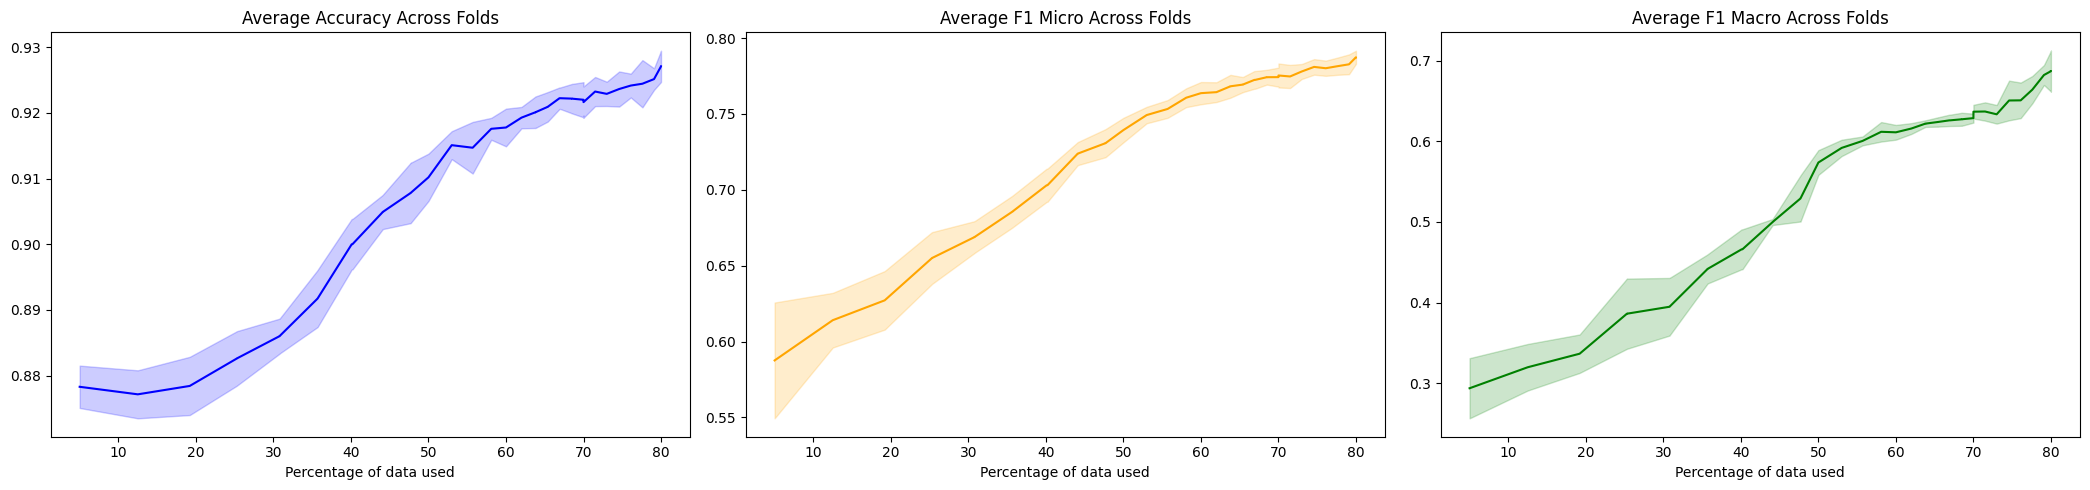

In [17]:
import matplotlib.pyplot as plt
import numpy as np

common_data_points = sorted(list(set(point for fold_points in all_fold_data_used for point in fold_points)))

# Interpolate metrics for each fold to the common data points
avg_accuracies = []
avg_f1_micros = []
avg_f1_macros = []
std_accuracies = []
std_f1_micros = []
std_f1_macros = []

for point in common_data_points:
    point_accuracies = []
    point_f1_micros = []
    point_f1_macros = []
    for i in range(N_SPLITS):
        sorted_indices = np.argsort(all_fold_data_used[i])
        sorted_data = np.array(all_fold_data_used[i])[sorted_indices]
        
        sorted_acc = np.array(all_fold_accuracies[i])[sorted_indices]
        sorted_f1m = np.array(all_fold_f1_micros[i])[sorted_indices]
        sorted_f1ma = np.array(all_fold_f1_macros[i])[sorted_indices]
        
        # Use interpolation to estimate the metric value at the common 'point'
        point_accuracies.append(np.interp(point, sorted_data, sorted_acc))
        point_f1_micros.append(np.interp(point, sorted_data, sorted_f1m))
        point_f1_macros.append(np.interp(point, sorted_data, sorted_f1ma))
    
    avg_accuracies.append(np.mean(point_accuracies))
    avg_f1_micros.append(np.mean(point_f1_micros))
    avg_f1_macros.append(np.mean(point_f1_macros))
    
    std_accuracies.append(np.std(point_accuracies))
    std_f1_micros.append(np.std(point_f1_micros))
    std_f1_macros.append(np.std(point_f1_macros))

# Convert to numpy arrays for easier plotting
avg_accuracies = np.array(avg_accuracies)
avg_f1_micros = np.array(avg_f1_micros)
avg_f1_macros = np.array(avg_f1_macros)
std_accuracies = np.array(std_accuracies)
std_f1_micros = np.array(std_f1_micros)
std_f1_macros = np.array(std_f1_macros)

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
data_used_percent = [round(data / len(X) * 100, 1) for data in common_data_points]

# Plot for Accuracy
axs[0].plot(data_used_percent, avg_accuracies, label="Avg Accuracy", color="blue")
axs[0].fill_between(data_used_percent, avg_accuracies - std_accuracies, avg_accuracies + std_accuracies, color='blue', alpha=0.2)
axs[0].set_xlabel("Percentage of data used")
axs[0].set_title("Average Accuracy Across Folds")

# Plot for F1 Micro
axs[1].plot(data_used_percent, avg_f1_micros, label="Avg F1 Micro", color="orange")
axs[1].fill_between(data_used_percent, avg_f1_micros - std_f1_micros, avg_f1_micros + std_f1_micros, color='orange', alpha=0.2)
axs[1].set_xlabel("Percentage of data used")
axs[1].set_title("Average F1 Micro Across Folds")

# Plot for F1 Macro
axs[2].plot(data_used_percent, avg_f1_macros, label="Avg F1 Macro", color="green")
axs[2].fill_between(data_used_percent, avg_f1_macros - std_f1_macros, avg_f1_macros + std_f1_macros, color='green', alpha=0.2)
axs[2].set_xlabel("Percentage of data used")
axs[2].set_title("Average F1 Macro Across Folds")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

for i in range(N_SPLITS):
    result = pd.DataFrame({
        'Data Used': all_fold_data_used[i],
        'Accuracy': all_fold_accuracies[i],
        'F1 Micro': all_fold_f1_micros[i],
        'F1 Macro': all_fold_f1_macros[i],
    })

    result.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)